<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/code/D2l_11_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Attention Pooling by Similarity

\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}\end{split}

In [2]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall:

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

All the kernels α(k,q) defined above are translation and rotation invariant, that is, if we shift and rotate k and q in same manner, the value of α remains unchanged

* Kernel 함수란?
    - 원점을 중심으로 좌우 대칭이면서 적분값이 1인 non-negative 함수로 정의되며 gaussian, epanechnikov, uniform 함수 등이 대표적인 커널 함수임

* Kernel Density Estimation(커널 밀도 추정)이란?
    - 커널 함수와 데이터를 바탕으로 연속성 있는 확률 밀도 함수를 추정하는 것
    - 밀도 추정 : 관측된 데이터들의 분포로부터 원래 변수의 확률 분포 특성을 추정하고자 하는 것

In [2]:
# Define Kernel functions
def gaussian(x):
    return torch.exp(-x**2/2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

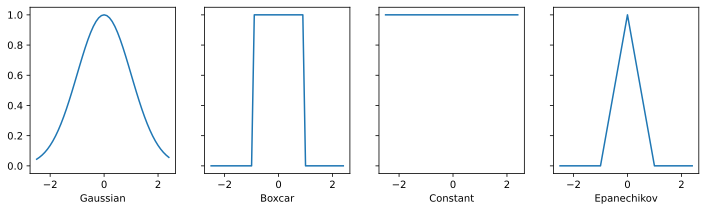

In [3]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)

for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Attention Pooling via Nadaraya--Watson Regression

In [6]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [4]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

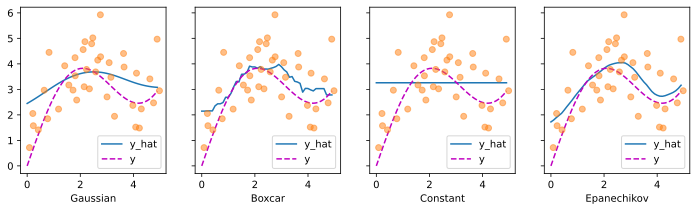

In [7]:
plot(x_train, y_train, x_val, y_val, kernels, names)

Adapting Attention Pooling

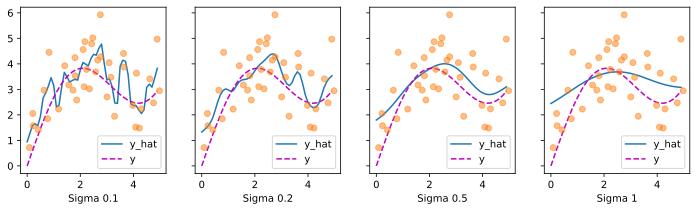

In [8]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

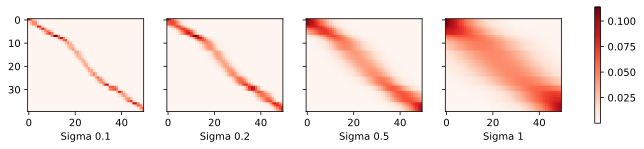

In [9]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

### Attention Scoring Functions

Masked Softmax Operation

In [10]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [11]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4782, 0.5218, 0.0000, 0.0000],
         [0.5306, 0.4694, 0.0000, 0.0000]],

        [[0.2362, 0.2646, 0.4993, 0.0000],
         [0.2532, 0.3143, 0.4325, 0.0000]]])

In [12]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3734, 0.3248, 0.3018, 0.0000]],

        [[0.6307, 0.3693, 0.0000, 0.0000],
         [0.1564, 0.3422, 0.2367, 0.2648]]])

Batch Matrix Multiplication

In [13]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Scaled Dot Product Attention

In [14]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [17]:
import math

queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

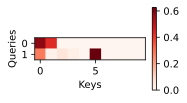

In [18]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

Additive Attention

In [19]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [20]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


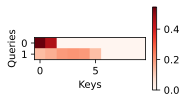

In [21]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### The Bahdanau Attention Mechanism

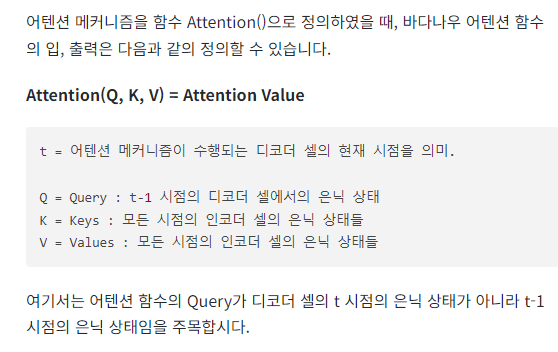